In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F #
import pandas as pd
import matplotlib.pyplot as plt

## Model

In [2]:
class NN(nn.Module):
    def __init__(self, input_size,num_output):
        super(NN,self).__init__()
        self.fc1 = nn.Linear(input_size,64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,num_output)

    def forward(self,x):
        # print(x)
        x = torch.tanh(self.fc1(x))
        # print(x)
        x = torch.tanh(self.fc2(x))
        # print(x)
        x = self.fc3(x)
        return x

model = NN(8,3)

## Train and Test divsion

In [3]:
df = pd.read_csv('dataset.csv')
index = df['n-class-0-latency'].index[df['n-class-0-latency'].apply(np.isnan)]
df = df.drop(index)

train_x = df[0:800][['ar-0','ar-1','ar-2','ar-3','pr-0','pr-1','pr-2','pr-3']].to_numpy()
test_x = df[800:][['ar-0','ar-1','ar-2','ar-3','pr-0','pr-1','pr-2','pr-3']].to_numpy()

train_y = df[0:800][['n-class-0-latency','n-class-1-bw','n-class-2-bw']].to_numpy()
test_y = df[800:][['n-class-0-latency','n-class-1-bw','n-class-2-bw']].to_numpy()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 800 # 28x28 = 784, size of MNIST images (grayscale)
num_output = 3


## Loss parameter

In [4]:
learning_rate = 0.01
num_epochs = 500

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss = []
loss_func = nn.MSELoss()


## Training

In [5]:
for epoch in range(num_epochs):
    where_are_NaNs = np.isnan(train_y)
    train_y[where_are_NaNs] = 0
    prediction = model(torch.from_numpy(train_x).float())

    loss = loss_func(prediction.float(), torch.from_numpy(train_y).float())
    # print(loss)
    optimizer.zero_grad()  # clear gradients for next train
    loss.backward()  # backpropagation, compute gradients
    optimizer.step()  # apply gradients
    train_loss.append(loss.data.numpy())

## Ploting training loss 

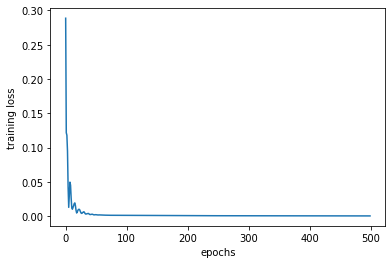

In [6]:
plt.xlabel('epochs')
plt.ylabel('training loss')
plt.plot(train_loss)
plt.show()

## Prediction loss

In [7]:
predict_test_y = model(torch.from_numpy(test_x).float())

test_loss = loss_func(predict_test_y.float(),torch.from_numpy(test_y).float())


prediction_un = predict_test_y.clone().detach().numpy()



## Unormalized predictions

In [8]:
prediction_un[:,0] = np.reciprocal(prediction_un[:,0])*0.320
prediction_un[:,1] = 13600*prediction_un[:,1]
prediction_un[:,2] = 13600*prediction_un[:,2]


test_y_un = np.copy(test_y)

test_y_un[:,0] = np.reciprocal(test_y[:,0])*0.320
test_y_un[:,1] = 13600*test_y[:,1]
test_y_un[:,2] = 13600*test_y[:,2]

x = np.concatenate((prediction_un,test_y_un),axis=1)

## Ploting and saving predictions

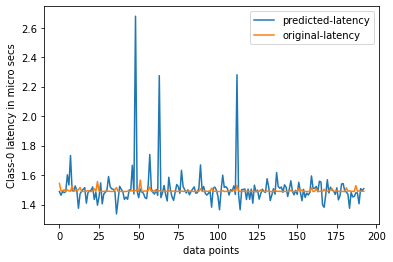

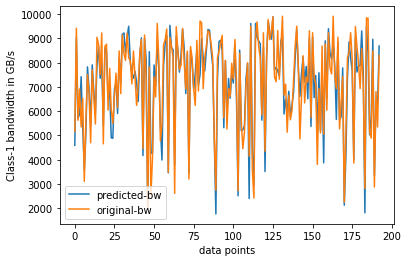

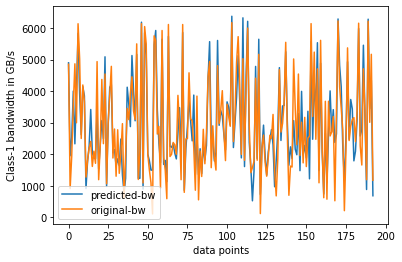

In [9]:
plt.plot(x[:,0],label='predicted-latency')
plt.plot(x[:,3],label='original-latency')
plt.xlabel('data points')
plt.ylabel('Class-0 latency in micro secs')
plt.legend()
plt.show()


plt.plot(x[:,1],label='predicted-bw')
plt.plot(x[:,4],label='original-bw')
plt.xlabel('data points')
plt.ylabel('Class-1 bandwidth in GB/s')
plt.legend()
plt.show()


plt.plot(x[:,2],label='predicted-bw')
plt.plot(x[:,5],label='original-bw')
plt.xlabel('data points')
plt.ylabel('Class-1 bandwidth in GB/s')
plt.legend()
plt.show()

np.savetxt('prediction_comparison.csv', x, delimiter =', ', header="p-class-0-lat,p-class-1-bw,p-class-2-bw,o-class-0-lat,o-class-1-bw,o-class-2-bw")


## Plotting ratios

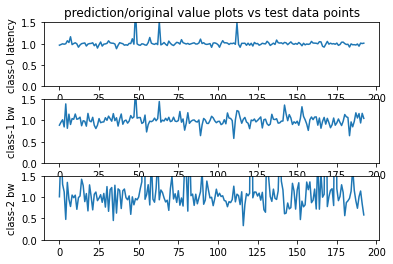

In [10]:
predict_test_y = model(torch.from_numpy(test_x).float())


a = []
for i in range(0,len(x[:,0])):
    a.append(float(x[:,0][i]/x[:,3][i]))
b = []
for i in range(0,len(x[:,1])):
    b.append(float(x[:,1][i]/x[:,4][i]))
c = []
for i in range(0,len(x[:,2])):
    c.append(float(x[:,2][i]/x[:,5][i]))

plt.subplot(3,1,1)
plt.title('prediction/original value plots vs test data points')
# plt.xlabel('test data points')
plt.ylabel('class-0 latency')

plt.plot(a)
plt.ylim((0, 1.5))

# plt.show()
plt.subplot(3,1,2)
plt.ylabel('class-1 bw')
plt.ylim((0, 1.5))

plt.plot(b)
# plt.show()

plt.subplot(3,1,3)
plt.ylabel('class-2 bw')
plt.ylim((0, 1.5))
plt.plot(c)

plt.show()

In [11]:
print(x)

[[1.48904848e+00 4.59127148e+03 4.89514307e+03 1.54381500e+00
  5.16486287e+03 4.84799028e+03]
 [1.46365166e+00 9.03428125e+03 1.95003650e+03 1.49337200e+00
  9.42325949e+03 9.11356211e+02]
 [1.48955548e+00 5.70968115e+03 2.52817358e+03 1.49419600e+00
  5.62524557e+03 1.94045305e+03]
 ...
 [1.50882614e+00 6.40106885e+03 3.44553467e+03 1.48959000e+00
  6.80698037e+03 3.01099181e+03]
 [1.49575543e+00 6.23539355e+03 4.34046045e+03 1.49082900e+00
  5.34848452e+03 5.16486645e+03]
 [1.50857770e+00 8.69038184e+03 6.85000549e+02 1.49134300e+00
  8.28946710e+03 1.17407679e+03]]


## Prediction

In [12]:
model.requires_grad_(requires_grad=False)
xin = torch.nn.Parameter(torch.tensor([3.0,13.0,3.0,47.0,7.0,41.0,86.0,90.0]), requires_grad=True)
optim = torch.optim.SGD([xin], lr=0.05)
mse = torch.nn.MSELoss()
y = torch.ones(3)  # the desired network response
num_steps = 1500  # how many optim steps to take
print('original x : ',xin )

for _ in range(num_steps):
   # pred_opt = model()
   loss = mse(model(xin), y)
   loss.backward()
   optim.step()
   optim.zero_grad()

print('xin after optimizing', xin)
# for param in model.parameters():
#     print(param)


xin = torch.nn.Parameter(torch.tensor([2.0,27.0,11.0,23.0,8.0,100.0,76.0,99.0]), requires_grad=True)
optim = torch.optim.SGD([xin], lr=0.05)
mse = torch.nn.MSELoss()
y = torch.ones(3)  # the desired network response
num_steps = 1500  # how many optim steps to take
print('original x : ',xin , )

for _ in range(num_steps):
   # pred_opt = model()
   loss = mse(model(xin), y)
   loss.backward()
   optim.step()
   optim.zero_grad()

print('xin after optimizing', xin)

original x :  Parameter containing:
tensor([ 3., 13.,  3., 47.,  7., 41., 86., 90.], requires_grad=True)
xin after optimizing Parameter containing:
tensor([ 2.8822, 13.1176,  3.2007, 46.9180,  6.9139, 41.0078, 86.0527, 89.9771],
       requires_grad=True)
original x :  Parameter containing:
tensor([  2.,  27.,  11.,  23.,   8., 100.,  76.,  99.], requires_grad=True)
xin after optimizing Parameter containing:
tensor([ 2.0154, 27.0200, 11.0043, 23.0143,  8.0218, 99.9886, 76.0000, 99.0000],
       requires_grad=True)


train_x
(993, 12)
test loss tensor(0.0034, grad_fn=<MseLossBackward>)
train_x
(993, 12)
test loss tensor(0.0029, grad_fn=<MseLossBackward>)
train_x
(993, 12)
test loss tensor(0.0033, grad_fn=<MseLossBackward>)
train_x
(993, 12)
test loss tensor(0.0023, grad_fn=<MseLossBackward>)
train_x
(993, 12)
test loss tensor(0.0020, grad_fn=<MseLossBackward>)
train_x
(993, 12)
test loss tensor(0.0019, grad_fn=<MseLossBackward>)
train_x
(993, 12)
test loss tensor(0.0020, grad_fn=<MseLossBackward>)
train_x
(993, 12)
test loss tensor(0.0019, grad_fn=<MseLossBackward>)
train_x
(993, 12)
test loss tensor(0.0015, grad_fn=<MseLossBackward>)
train_x
(993, 12)
test loss tensor(0.0015, grad_fn=<MseLossBackward>)
train_x
(993, 12)
test loss tensor(0.0015, grad_fn=<MseLossBackward>)
train_x
(993, 12)
test loss tensor(0.0019, grad_fn=<MseLossBackward>)
train_x
(993, 12)
test loss tensor(0.0016, grad_fn=<MseLossBackward>)
train_x
(993, 12)
test loss tensor(0.0015, grad_fn=<MseLossBackward>)
train_x
(993, 12)
te

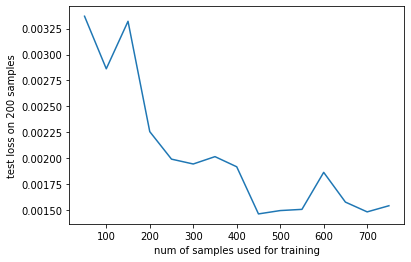

In [15]:
df = pd.read_csv('dataset.csv')
index = df['n-class-0-latency'].index[df['n-class-0-latency'].apply(np.isnan)]


df = df.drop(index)
test_loss_list = []
num_of_samples = []
for j in range(1,16):
    model = NN(8, 3)
    num_of_samples.append(50*j)
    train_x = df[0:50*j][['ar-0','ar-1','ar-2','ar-3','pr-0','pr-1','pr-2','pr-3']].to_numpy()
    test_x = df[800:][['ar-0','ar-1','ar-2','ar-3','pr-0','pr-1','pr-2','pr-3']].to_numpy()
    print('train_x')
    print(df.shape)
    train_y = df[0:50*j][['n-class-0-latency','n-class-1-bw','n-class-2-bw']].to_numpy()
    test_y = df[800:][['n-class-0-latency','n-class-1-bw','n-class-2-bw']].to_numpy()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_size = 800 # 28x28 = 784, size of MNIST images (grayscale)
    num_output = 3
    learning_rate = 0.01
    num_epochs = 500


    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loss = []
    loss_func = nn.MSELoss()
    for epoch in range(num_epochs):

        prediction = model(torch.from_numpy(train_x).float())

        loss = loss_func(prediction.float(), torch.from_numpy(train_y).float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data.numpy())

    predict_test_y = model(torch.from_numpy(test_x).float())

    prediction_un = predict_test_y.clone().detach().numpy()

    test_loss = loss_func(predict_test_y.float(),torch.from_numpy(test_y).float())
    test_loss_list.append(test_loss.detach().numpy())
    print('test loss',test_loss)


plt.xlabel('num of samples used for training')
plt.ylabel('test loss on 200 samples')

plt.plot(num_of_samples,test_loss_list)
plt.show()




In [20]:
model.requires_grad_(requires_grad=False)
x = torch.nn.Parameter(torch.tensor([3.0,13.0,3.0,47.0,7.0,41.0,86.0,90.0]), requires_grad=True)
optim = torch.optim.SGD([x], lr=0.05)
mse = torch.nn.MSELoss()
y = torch.ones(3)  # the desired network response
num_steps = 1500  # how many optim steps to take
print('original x : ',x , )





for _ in range(num_steps):
   # pred_opt = model()
   loss = mse(model(x), y)
   loss.backward()
   optim.step()
   optim.zero_grad()

print('x', x)
# for param in model.parameters():
#     print(param)


x = torch.nn.Parameter(torch.tensor([2.0,27.0,11.0,23.0,8.0,100.0,76.0,99.0]), requires_grad=True)
optim = torch.optim.SGD([x], lr=0.1)
mse = torch.nn.MSELoss()
y = torch.ones(3)  # the desired network response
num_steps = 1500  # how many optim steps to take
print('original x : ',x , )

for _ in range(num_steps):
   # pred_opt = model()
   loss = -torch.sum(model(x))
#    print(loss)
   loss.backward()
   optim.step()
   optim.zero_grad()

print('x', x)

original x :  Parameter containing:
tensor([ 3., 13.,  3., 47.,  7., 41., 86., 90.], requires_grad=True)
x Parameter containing:
tensor([ 3.1894, 13.1581,  3.1318, 46.8564,  6.9982, 41.0932, 85.9383, 90.0572],
       requires_grad=True)
original x :  Parameter containing:
tensor([  2.,  27.,  11.,  23.,   8., 100.,  76.,  99.], requires_grad=True)
x Parameter containing:
tensor([  1.9712,  27.0320,  11.0057,  23.0029,   7.9887, 100.0458,  75.9542,
         98.9771], requires_grad=True)


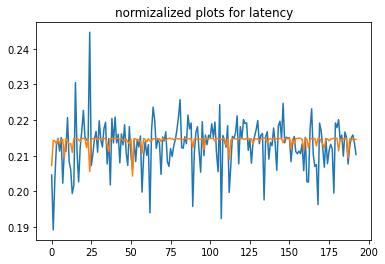

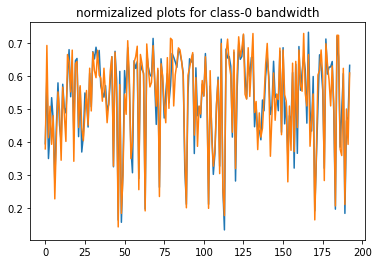

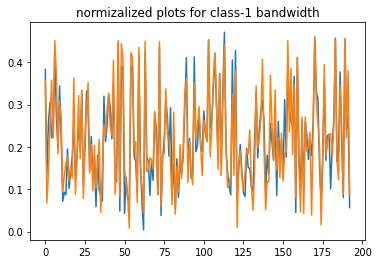

In [21]:
plt.title('normizalized plots for latency')
plt.plot(predict_test_y[:,0].data.numpy(),label="predicted latency")
plt.plot(test_y[:,0],label="test latency")
plt.show()


plt.title('normizalized plots for class-0 bandwidth')
plt.plot(predict_test_y[:,1].data.numpy(),label="predicted bandwidth")
plt.plot(test_y[:,1],label="test bandwidth")
plt.show()


plt.title('normizalized plots for class-1 bandwidth')
plt.plot(predict_test_y[:,2].data.numpy(),label="predicted bandwidth")
plt.plot(test_y[:,2],label="test bandwidth")
plt.show()


In [22]:
print('complete')

complete
